# Introduction to `qiskit-pasqal-provider`

In [1]:
import os
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, InterpolatedWaveform, AnalogDevice
from pulser_simulation import QutipEmulator

# define user config
user = os.environ.get("PASQAL_ID", None)
psswd = os.environ.get("PASQAL_CLOUD_PASSWORD", None)
project_id = os.environ.get("PASQAL_QISKIT_PROJECT_ID", None)

# QPP

`qiskit-pasqal-provider` (QPP) is way for Qiskit users to program Pasqal's analog neutral atoms devices.




## 2. Build circuits with analog gate


### 2.1 `HamiltonianGate`

The analog gate, `HamiltonianGate`, is defined by the following parameters:

- `amplitude`: `InterpolatePoints`
  
- `detuning`: `InterpolatePoints`
- `phase`: `float`, `qiskit`'s `Parameter` or `ParameterExpression`

- `coords`: any value pair array-like data

- `grid_transform`: one of the following `Literal`: `"triangular"`, `"rectangular"` or `"square"`


### 2.2 `InterpolatePoints`

It is a class to create interpolate points given an array of values (literal or parametrized)

In [2]:
from qiskit_pasqal_provider.providers.gate import InterpolatePoints

In [3]:
# literal

ampl1 = InterpolatePoints(duration=1000, values=[1, 1, 1, 1])

print(f"\n- {ampl1.values=}\n\n- {ampl1.duration=}\n")


- ampl1.values=array([1, 1, 1, 1])

- ampl1.duration=1000



In [4]:
# parametrized

from qiskit.circuit import Parameter


p = Parameter("p")
t = Parameter("t")

ampl2 = InterpolatePoints(duration=t, values=p, n=4)

print(f"\n- {ampl2.values=}\n\n- {ampl2.duration=}\n")


- ampl2.values=array([Parameter(p), Parameter(p), Parameter(p), Parameter(p)],
      dtype=object)

- ampl2.duration=Parameter(t)



### 2.3 Defining the coordinates

The `coords` argument should be look like a 2D- or 3D-point tuple array.

In [5]:
# valid coords

coords1 = [(0, 0), (0, 1), (1, 0), (1, 1)]
coords2 = [(0, 0, 0), (0, 1, 0), (1, 0, 1), (1, 1, 0)]

In [6]:
# invalid coords

coords3 = []
coords4 = [(0,), (1,), (2,), (3,)]


**Note**: `coords` data will be validated inside the `HamiltonianGate`. An error will raise if they do not comply with `pulser.Register` requirements.

---


### 2.4 Building the gate

In [7]:
from qiskit_pasqal_provider.providers.gate import HamiltonianGate

In [8]:
ampl = InterpolatePoints(duration=1000, values=[1, 1, 1, 1])
det = InterpolatePoints(duration=1000, values=[0, 1 / 3, 2 / 3, 1])
phase = 0.0


hg = HamiltonianGate(
    amplitude=ampl, detuning=det, phase=phase, coords=coords1, transform=True
)

print(hg)

Instruction(name='HG', num_qubits=4, num_clbits=0, params=[])


**Important remarks**:

- `HamiltonianGate` is just like any other `qiskit` gate in the sense that is composible by an `Instruction` instance and can be placed inside the `QuantumCircuit`.

- The number of qubits are defined by the length of the `coords` argument.

- When working with analog gate, **only one gate** can be placed inside the given `QuantumCircuit`, may it be analog or not.

### 2.5 Defining the `QuantumCircuit`

A circuit can be built as any other `qiskit` circuit:

In [9]:
from qiskit.circuit import QuantumCircuit

In [10]:
# define the size of the circuit according to the coords1 used on HamiltonianGate above

qc1 = QuantumCircuit(len(coords1))

then, append the gate to the defined `qc` circuit:


In [11]:
qc1.append(hg, qc1.qubits)

remarks:

- Given the nature of `qiskit` circuits, when appending a new gate, you need to define the number of qubits.

- We always use the total number of the qubits given by the coordinates and defined in the `QuantumCircuit`, which is also stored in `QuantumCircuit.qubits` property

In [12]:
qc1.draw()  # not very exciting, I know

┌─────┐
q_0: ┤0    ├
     │     │
q_1: ┤1    ├
     │  Hg │
q_2: ┤2    ├
     │     │
q_3: ┤3    ├
     └─────┘

**Important remarks**:

- In this analog gate configuration, the actual register (for `pulser` purposes) sits inside the `HamiltonianGate`, not in the `QuantumCircuit`.

- The whole dynamics of your algorithm must be done inside the single `HamiltonianGate`, through `InterpolatePoints` functions.

#### 2.5.1 Parametrized `QuantumCircuit`

It is possible to do parametrized circuits as well:

In [13]:
p = Parameter("p")
d = Parameter("d")

ampl2 = InterpolatePoints(duration=1000, values=p, n=4)
det2 = InterpolatePoints(duration=1000, values=d, n=4)

hg2 = HamiltonianGate(amplitude=ampl2, detuning=det2, phase=phase, coords=coords1)

qc2 = QuantumCircuit(len(coords1))
qc2.append(hg2, qc2.qubits)
qc2.draw()  # at least it shows the parameters

┌──────────┐
q_0: ┤0         ├
     │          │
q_1: ┤1         ├
     │  Hg(p,d) │
q_2: ┤2         ├
     │          │
q_3: ┤3         ├
     └──────────┘

## 3. Create and run a simple program

Now, following the `qiskit` formula, we can create and run a program using our analog gate

First, defining the coordinates and drawing how the register will look like

In [14]:
from pulser import Register

In [15]:
coords = [[0, 0], [3, 5.2], [6, 0], [9, -5.2], [9, 5.2], [12, 0]]

# With a blockade radius of 8.7
blockade_radius = 8.7

/home/runner/work/qiskit-pasqal-provider/qiskit-pasqal-provider/.tox/docs/lib/python3.12/site-packages/pulser/register/register.py:58: DeprecationWarning: Usage of `int`s or any non-`str`types as `QubitId`s will be deprecated. Define your `QubitId`s as `str`s, prefer setting `prefix='q'` when using classmethods, as that will become the new default once `int` qubit IDs become invalid.
  super().__init__(qubits, **kwargs)


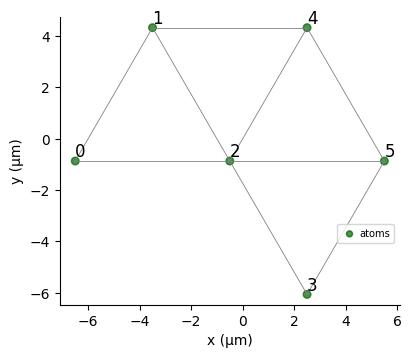

In [16]:
# show graph
reg = Register.from_coordinates(coords)
reg.draw(blockade_radius=blockade_radius)

By default, a layout is filled according to the coordinates and the requirements given by the provider instance.

But it can be defined explicitly by the user:

In [17]:
from qiskit_pasqal_provider.providers.target import PasqalTarget

In [18]:
target = PasqalTarget(layout=None)

If `layout` argument is none (default), the backend will perform a `register.with_automatic_layout()` call.

For more information, request access to the `qiskit-pasqal-provider` repository.

In [19]:
from qiskit_pasqal_provider.providers.gate import InterpolatePoints, HamiltonianGate

In [20]:
# Calculate interaction strength between nearest-neighbours
interaction = 5420158.53 / blockade_radius**6

# Set up an adiabatic pulse
times = [0, 0.2, 0.8, 1]
ampl = InterpolatePoints(values=[0, 4, 4, 0], times=times)
det = InterpolatePoints(
    values=[-10, -10, interaction / 2, interaction / 2],
    times=times,
)
phase = 0.0

In [21]:
# analog gate
gate = HamiltonianGate(ampl, det, phase, coords, grid_transform="triangular")

# qiskit circuit with analog gate
qc = QuantumCircuit(len(coords))
qc.append(gate, qc.qubits)

### 3.1 Running on pure `pulser` for comparison

Utilizing the code above for pulser

In [22]:
ampl_p = InterpolatedWaveform(1000, [0, 4, 4, 0], times=times)
det_p = InterpolatedWaveform(
    1000, [-10, -10, interaction / 2, interaction / 2], times=times
)
phase_p = 0.0

pulse = Pulse(ampl_p, det_p, phase_p)

seq = Sequence(reg, AnalogDevice)
seq.declare_channel("rydberg_global", "rydberg_global")
seq.add(pulse, "rydberg_global")
bkd = QutipEmulator.from_sequence(seq)
results = bkd.run()

pulser_res = results.sample_final_state()

In [23]:
from qiskit_pasqal_provider.providers.provider import PasqalProvider
from qiskit_pasqal_provider.providers.sampler import SamplerV2

### 3.2 Running examples on different devices


Following `qiskit` convention, a provider consists in the service that contains the backend, target (device) and additional information, such as remote configuration.

There is two possible ways to execute a circuit and extract results from it: estimator and sampler. `QPP` _only uses sampler approach for now_.

From the sampler object, it is possible to run a circuit and get its results as `qiskit` result object.

To retrieve the counts, just use `result[0].data.counts`.

#### 3.2.1 Local emulator: `QuTip`

In [24]:
qc_qutip = deepcopy(qc)

provider_qutip = PasqalProvider()
backend_qutip = provider_qutip.get_backend("qutip")
sampler_qutip = SamplerV2(backend_qutip)
results_qutip = sampler_qutip.run([qc_qutip], shots=2000).result()

res_qutip = results_qutip[0].data.counts

#### 3.2.2 Local emulator: `Emu-MPS`

In [25]:
qc_mps = deepcopy(qc)

provider_mps = PasqalProvider()
backend_mps = provider_mps.get_backend("emu-mps")
sampler_mps = SamplerV2(backend_mps)
results_mps = sampler_mps.run([qc_mps], shots=2000).result()

res_mps = results_mps[0].data.counts

step = 1/100, χ = 1, |ψ| = 0.000 MB, RSS = 691.572 MB, Δt = 0.120 s


step = 2/100, χ = 1, |ψ| = 0.000 MB, RSS = 691.572 MB, Δt = 0.028 s


step = 3/100, χ = 1, |ψ| = 0.000 MB, RSS = 691.572 MB, Δt = 0.027 s


step = 4/100, χ = 2, |ψ| = 0.000 MB, RSS = 691.740 MB, Δt = 0.028 s


step = 5/100, χ = 3, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.039 s


step = 6/100, χ = 3, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.042 s


step = 7/100, χ = 3, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.042 s


step = 8/100, χ = 3, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.042 s


step = 9/100, χ = 3, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.042 s


step = 10/100, χ = 3, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.043 s


step = 11/100, χ = 4, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.042 s


step = 12/100, χ = 4, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.042 s


step = 13/100, χ = 4, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.042 s


step = 14/100, χ = 4, |ψ| = 0.001 MB, RSS = 691.740 MB, Δt = 0.042 s


step = 15/100, χ = 5, |ψ| = 0.002 MB, RSS = 691.996 MB, Δt = 0.042 s


step = 16/100, χ = 5, |ψ| = 0.002 MB, RSS = 691.996 MB, Δt = 0.042 s


step = 17/100, χ = 5, |ψ| = 0.002 MB, RSS = 691.996 MB, Δt = 0.043 s


step = 18/100, χ = 5, |ψ| = 0.002 MB, RSS = 691.996 MB, Δt = 0.043 s


step = 19/100, χ = 5, |ψ| = 0.002 MB, RSS = 691.996 MB, Δt = 0.042 s


step = 20/100, χ = 5, |ψ| = 0.002 MB, RSS = 691.996 MB, Δt = 0.042 s


step = 21/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 22/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 23/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 24/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 25/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 26/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 27/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 28/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.045 s


step = 29/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.059 s


step = 30/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.055 s


step = 31/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 32/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 33/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 34/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 35/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 36/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 37/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 38/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 39/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 40/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 41/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 42/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 43/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 44/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 45/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.045 s


step = 46/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 47/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 48/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 49/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.040 s


step = 50/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.039 s


step = 51/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.039 s


step = 52/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.040 s


step = 53/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.039 s


step = 54/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.039 s


step = 55/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.039 s


step = 56/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.038 s


step = 57/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.033 s


step = 58/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.033 s


step = 59/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.034 s


step = 60/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.034 s


step = 61/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.041 s


step = 62/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.041 s


step = 63/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.041 s


step = 64/100, χ = 6, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.041 s


step = 65/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.041 s


step = 66/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 67/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 68/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 69/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 70/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 71/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 72/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 73/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 74/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 75/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 76/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.044 s


step = 77/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 78/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 79/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 80/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.044 s


step = 81/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 82/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 83/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 84/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 85/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 86/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 87/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.042 s


step = 88/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 89/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.045 s


step = 90/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.044 s


step = 91/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 92/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.044 s


step = 93/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 94/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 95/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 96/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.043 s


step = 97/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.044 s


step = 98/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.044 s


step = 99/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.124 MB, Δt = 0.044 s


step = 100/100, χ = 7, |ψ| = 0.002 MB, RSS = 692.764 MB, Δt = 0.199 s


### Remote execution

Remote execution requires a `RemoteConfig` object to be placed on `PasqalProvider`. It must contain at least the username, project id and password.

The code is exactly the same otherwise.

In [26]:
from qiskit_pasqal_provider.utils import RemoteConfig

config = RemoteConfig(username=user, password=psswd, project_id=project_id)

#### 3.2.3 Remote emulator: `Emu-Free`

In [27]:
if config.username:
    qc_free = deepcopy(qc)

    provider_free = PasqalProvider(remote_config=config)
    backend_free = provider_free.get_backend("remote-emu-free")
    sampler_free = SamplerV2(backend_free)
    results_free = sampler_free.run([qc_free], shots=2000).result()

    res_free = results_free[0].data.counts

#### 3.2.4 Remote emulator: `Emu-Fresnel`

In [28]:
if config.username:
    qc_emu_fresnel = deepcopy(qc)

    provider_emu_fresnel = PasqalProvider(remote_config=config)
    backend_emu_fresnel = provider_emu_fresnel.get_backend("remote-emu-fresnel")
    sampler_emu_fresnel = SamplerV2(backend_emu_fresnel)
    results_emu_fresnel = sampler_emu_fresnel.run([qc_emu_fresnel], shots=400).result()

    res_rem_mps = results_emu_fresnel[0].data.counts

### Comparison between backends

The plot below compares the bitstrings from each of the backends run above.

Note that `Emu-Fresnel` (a remote backend that emulates the Fresnel device specs) run with less shots than the others, which may result in bigger variances.

In [29]:
def get_kv(data):
    _a = ()
    _b = ()
    _total = sum(data.values())
    for k, v in data.items():
        _a += (k,)
        _b += (v / _total,)
    return _a, _b


def get_counter(*dataset):
    _ks = dict()
    _ds = []

    for p in dataset:
        _k, _d = get_kv(p)
        _ds.append(dict(zip(_k, _d)))
        for _w, _t in p.items():
            if _w in _ks:
                _ks[_w] += _t
            else:
                _ks[_w] = _t

    for _x in _ds:
        for _c in _ks:
            if _c not in _x:
                _x[_c] = 0.0

    _ks = dict(sorted(_ks.items(), key=lambda _y: _y[1], reverse=True))
    return [{k: d[k] for k in _ks} for d in _ds], _ks

In [30]:
def comparison_plot(data, size=5):
    fig = plt.figure(figsize=(12, 7))
    w = 0.1

    ax = fig.add_subplot(111)

    x_data = np.array(range(len(data[0])))[:size]

    for n, (k, v) in enumerate(
        zip(srs, ("pulser", "qutip", "emu-mps", "emu-free", "emu-fresnel"))
    ):
        plt.bar(
            x_data - 2 * w + (n * w), list(k.values())[:size], w, label=v, align="edge"
        )

    plt.title("Comparison between backends results")
    plt.ylabel("Probability distribution")
    plt.xlabel("Bitstring")
    plt.xticks(np.arange(0, size), list(data[0])[:size])
    plt.legend()
    plt.show()

In [31]:
srs, crc = get_counter(pulser_res, res_qutip, res_mps)  # , res_free, res_rem_mps)

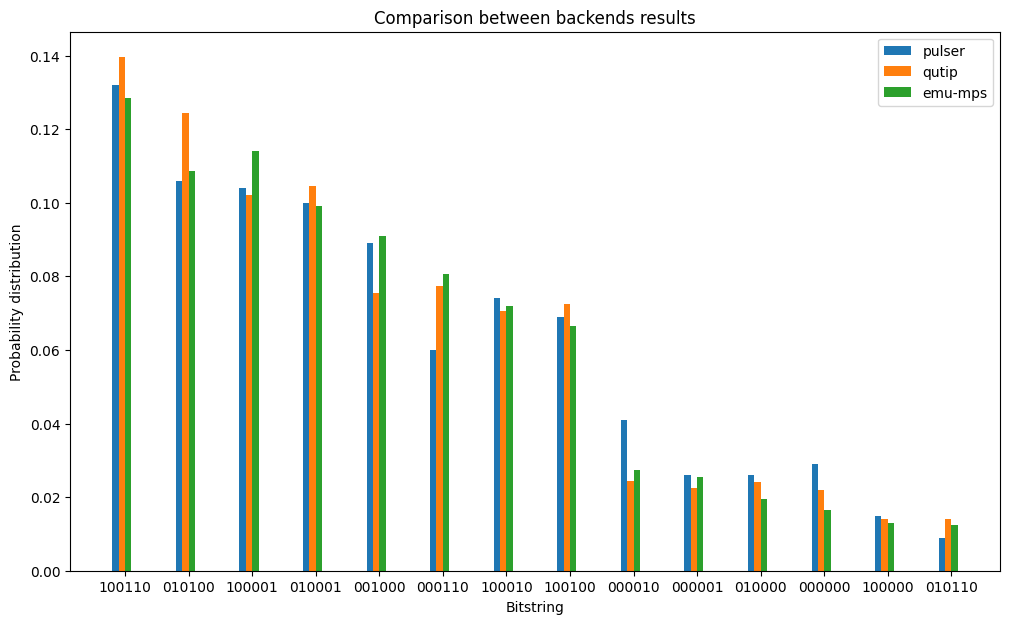

In [32]:
comparison_plot(srs, 14)

### 3.6 QPU

It is also possible to run the same circuit on the QPU (if it is available).